$$ \LARGE
\underline{\textbf{Problema 1}}
$$

Se tiene una placa cuadrada de aluminio cuyos bordes están en las condiciones que se indican en la
figura: tres lados a temperaturas fijas y otro, el inferior, aislado térmicamente (flujo de calor igual a
cero). Encuentre, utilizando el método de diferencias finitas, los valores de temperatura y flujo de
calor para cada punto. Utilice primero la grilla señalada y luego generalice el problema a un número
variable de nodos en cada eje de coordenadas. Haga un estudio del tiempo de cálculo en función del
tamaño del sistema.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

$$
$$

In [2]:
class Chapa:
    def __init__(self, nx, ny=None):
        self.nx = nx
        if ny is None:
            self.ny = nx
        else:
            self.ny = ny
        self.nk = self.nx * self.ny
        # Muestro la posición de cada borde
        self.bordeA = np.linspace(0, self.nk-self.nx, self.ny).astype(int)
        self.bordeB = np.linspace(0, self.nx-1, self.nx).astype(int)
        self.bordeC = np.linspace(self.nx, self.nk-1, self.ny).astype(int)
        self.bordeD = np.linspace(self.nk-self.nx, self.nk-1, self.nx).astype(int)

    # entonces tendrías un método de definir la matriz
    def makematriz(self, TC, tipocontorno={'A': 'temp', 'B': 'temp', 'C': 'temp', 'D': 'temp'}):

        # TA es la temp de la izquierda, TB de abajo, TC derecha, TD arriba
        # Se establece que el tipo de contorno es de todas temperaturas fijas

        self.TC = TC
        self.tipocontorno = tipocontorno
        beta = self.nx/self.ny
        b = np.zeros([self.nx*self.ny, 1])  # Conviene que sea de ceros
        M = np.eye(self.nx*self.ny)

        for k in range(self.nk):

            # Vertice 1 (abajo a la izquierda)
            if k == 0:
                if self.tipocontorno['A'] == 'temp' and self.tipocontorno['B'] == 'flujo':
                    b[k] = TC['A']
                elif self.tipocontorno['B'] == 'temp' and self.tipocontorno['A'] == 'flujo':
                    b[k] = TC['B']
                else:
                    b[k] = (TC['A']+TC['B'])/2

            # Vertice 2 (abajo a la derecha)
            elif k == (self.nx-1):
                if self.tipocontorno['C'] == 'temp' and self.tipocontorno['B'] == 'flujo':
                    b[k] = TC['C']
                elif self.tipocontorno['B'] == 'temp' and self.tipocontorno['C'] == 'flujo':
                    b[k] = TC['B']
                else:
                    b[k] = (TC['C']+TC['B'])/2

            # Vertice 3 (arriba a la derecha)
            elif k == self.nx*self.ny-self.nx:
                if self.tipocontorno['A'] == 'temp' and self.tipocontorno['D'] == 'flujo':
                    b[k] = TC['A']
                elif self.tipocontorno['D'] == 'temp' and self.tipocontorno['A'] == 'flujo':
                    b[k] = TC['D']
                else:
                    b[k] = (TC['A']+TC['D'])/2

            # Vertice 4 (arriba a la izquierda)
            elif k == self.nx*self.ny-1:
                if self.tipocontorno['C'] == 'temp' and self.tipocontorno['D'] == 'flujo':
                    b[k] = TC['C']
                elif self.tipocontorno['D'] == 'temp' and self.tipocontorno['C'] == 'flujo':
                    b[k] = TC['D']
                else:
                    b[k] = (TC['C']+TC['D'])/2

            # Borde inferior
            elif k in self.bordeB:
                b[k] = TC['B']
                if self.tipocontorno['B'] == 'flujo':
                    M[k, k] = -2*(1+beta**2)
                    M[k, k-1] = 1
                    M[k, k+1] = 1
                    M[k, k+self.nx] = 2*beta**2
                    M[k, k-self.nx] = 0

            # Borde superior
            elif k in self.bordeD:
                b[k] = TC['D']
                if self.tipocontorno['D'] == 'flujo':
                    M[k, k] = -2*(1+beta**2)
                    M[k, k-1] = 1
                    M[k, k+1] = 1
                    M[k, k+self.nx] = 0
                    M[k, k-self.nx] = 2*beta**2

            # Borde izquierdo
            elif k in self.bordeA:
                b[k] = TC['A']
                if self.tipocontorno['A'] == 'flujo':
                    M[k, k] = -2*(1+beta**2)
                    M[k, k+1] = 2
                    M[k, k-self.nx] = beta**2
                    M[k, k+self.nx] = beta**2

            # Borde derecho
            elif k in self.bordeC:
                b[k] = TC['C']
                if self.tipocontorno['C'] == 'flujo':
                    M[k, k] = -2*(1+beta**2)
                    M[k, k-1] = 2
                    M[k, k-self.nx] = beta**2
                    M[k, k+self.nx] = beta**2

            # Fuera de los contornos (interior de la chapa)
            else:
                M[k, k] = -2*(1+beta**2)
                M[k, k-1] = 1
                M[k, k+1] = 1
                M[k, k-self.nx] = beta**2
                M[k, k+self.nx] = beta**2

        self.M = M  # Hacemos que sean propiedades del objeto chapa
        self.b = b

        return M, b

    def solve(self, M, b):
        T = np.linalg.solve(M, b)
        T_matriz = T.reshape(self.nx, self.ny)
        T_matriz = T_matriz[::-1]
        self.T_matriz = T_matriz
        return self.T_matriz

    def plot_temp(self, T_matriz):
        plt.rc('figure', figsize=(16, 8))
        plt.rc('font', size=22)
        mapable = plt.imshow(T_matriz)
        cbar = plt.colorbar(mapable)
        cbar.set_label('T(ºC)')
        plt.xlabel(' i ')
        plt.ylabel(' j ')
        return mapable

    def plot_flujo(self, T_matriz):
        T_matriz = T_matriz[::-1]
        fig, ax = plt.subplots(figsize=(15, 11))
        mappable = ax.contourf(T_matriz)
        levels = ax.contour(T_matriz, colors='k', linewidths=5)
        cbar = plt.colorbar(mappable)
        cbar.set_label('T[°C]')
        ax.clabel(levels,)
        ax.set_xlabel('i')
        ax.set_ylabel('j')
        return mappable

In [3]:
TC = {'A': 75, 'B': 0, 'C': 50, 'D': 100}
lachapa = Chapa(10)

In [4]:
M, b = lachapa.makematriz(TC)

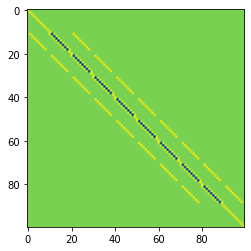

In [5]:
plt.imshow(M)

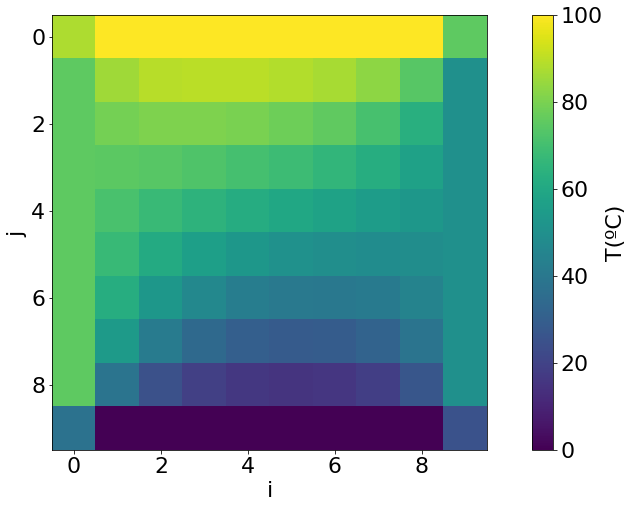

In [6]:
T_matriz = lachapa.solve(M, b)
lachapa.plot_temp(T_matriz)

In [7]:
ns = np.logspace(1, 2, 10).astype(int)

$$
$$

# Determino el tiempo de calculo del sistema en función de la resolución de la grilla

In [8]:
dts = []
for ni in ns:
    thischapa = Chapa(ni)
    M, b = thischapa.makematriz(TC)
    t1 = time.time()
    thischapa.solve(M, b)
    t2 = time.time()
    dts.append(t2-t1)

In [9]:
dts

[0.00018310546875,
 0.00037932395935058594,
 0.00203704833984375,
 0.004076719284057617,
 0.007767200469970703,
 0.026430606842041016,
 0.08092594146728516,
 0.22201824188232422,
 0.9513082504272461,
 4.420013904571533]

Ahora hay que ver el escaleo. Esto tiene que seguir una ley $dt = Nx^p$ , donde $p$ viene dado por el conteo de operaciones en la triangulación de gauss.

$$
log{(dt)}=p \cdot log(x)+log(N)
$$

In [10]:
model = np.polyfit(np.log10(ns[2:]), np.log10(dts[2:]), 1)

No considero los dos puntos porque a veces en dts son 0 y estamos calculando el logaritmo

In [11]:
model

array([ 4.20268841, -7.97205329])

polyfit resuelve el polinomio devolviendo los valores de $p$ y de $log(N)$

resulta que:

$p\ =\ model[0]$

Creo una función de 1 <sup>er</sup> orden con las constantes obtenidas

In [12]:
function = np.poly1d(model)

In [13]:
function

poly1d([ 4.20268841, -7.97205329])

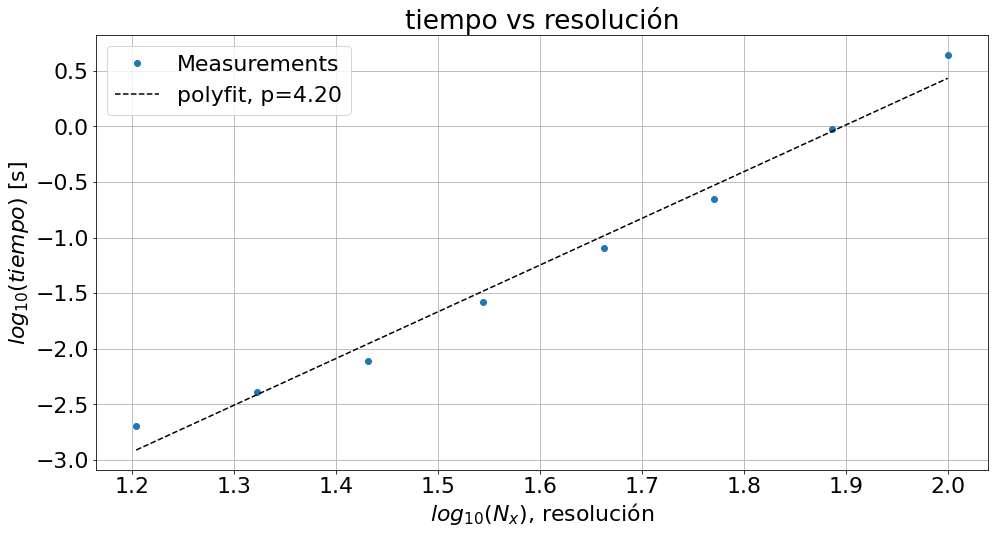

In [14]:
plt.plot(np.log10(ns[2:]), np.log10(dts[2:]), 'o', label='Measurements')  # 
plt.plot(np.log10(ns[2:]), function(np.log10(ns[2:])), '--k', label=f'polyfit, p={model[0]:3.2f}')
plt.xlabel(r'$log_{10} (N_x) $, resolución')
plt.ylabel(r'$log_{10} (tiempo) $ [s]')
plt.title('tiempo vs resolución')
plt.grid('on')
plt.legend()

$$
$$

# \underline{\textbf{Chapa con flujo en una cara}}

<div style="background:#999900"> lo que pasa es qu en A tenes un flujo no nulo! po lo tanto el resultado que estabas obteniendo tal vez esté bien !</div>

In [15]:
#TC = {'A': 75, 'B': 0, 'C': 50, 'D': 100}
TC = {'A': 0, 'B': 0, 'C': 50, 'D': 100}
tipocontorno = {'A': 'flujo', 'B': 'temp', 'C': 'temp', 'D': 'temp'}
lachapa = Chapa(10)
M, b = lachapa.makematriz(TC, tipocontorno)

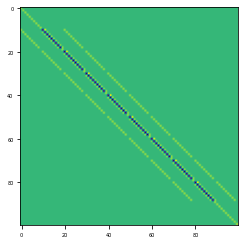

In [16]:
plt.rc('figure', figsize=(4, 4))
plt.rc('font', size=5)

plt.imshow(M)

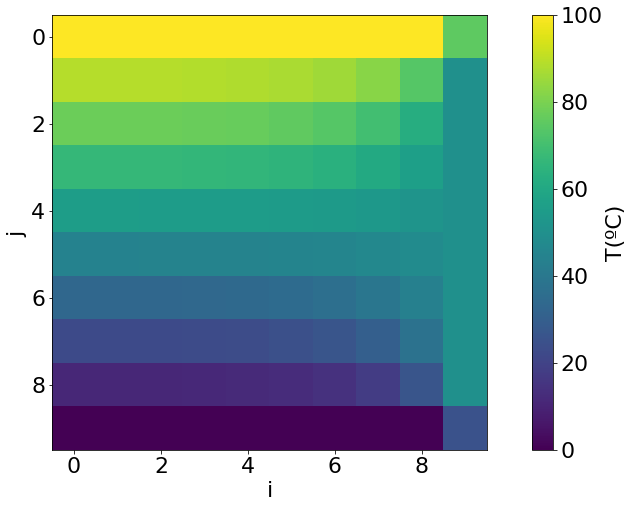

In [17]:
T_matriz = lachapa.solve(M, b)
lachapa.plot_temp(T_matriz)

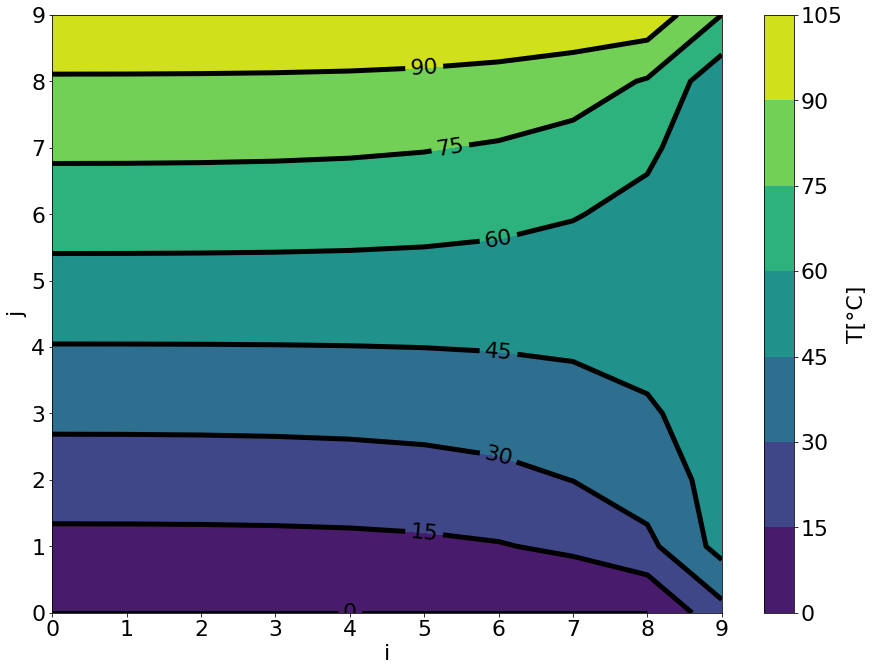

In [18]:
lachapa.plot_flujo(T_matriz)

$$
$$